In [5]:
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/자연어처리_기말고사대비_1.ipynb" --ClearMetadataPreprocessor.enabled=True

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/자연어처리_기말고사대비_1.ipynb to html
/usr/local/share/jupyter/nbconvert/templates/base/display_priority.j2:32: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.colab-display-data+json']) is not able to be represented.
  {%- elif type == 'text/vnd.mermaid' -%}
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 551276 bytes to /content/drive/MyDrive/Colab Notebooks/자연어처리_기말고사대비_1.html


# 0. 환경 세팅

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip uninstall -y transformers tokenizers accelerate datasets

!pip install --no-cache-dir --force-reinstall -U transformers accelerate datasets peft scikit-learn


Found existing installation: transformers 4.57.3
Uninstalling transformers-4.57.3:
  Successfully uninstalled transformers-4.57.3
Found existing installation: tokenizers 0.22.1
Uninstalling tokenizers-0.22.1:
  Successfully uninstalled tokenizers-0.22.1
Found existing installation: accelerate 1.12.0
Uninstalling accelerate-1.12.0:
  Successfully uninstalled accelerate-1.12.0
Found existing installation: datasets 4.0.0
Uninstalling datasets-4.0.0:
  Successfully uninstalled datasets-4.0.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 179.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 142.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 198.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 245.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 198.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [1]:
import transformers
from transformers import TrainingArguments

TrainingArguments.__init__.__annotations__
print(transformers.__version__)


4.57.3


# 1. 데이터셋 로드/분할 & 모델 학습

In [ ]:
# 라벨 정의
label2id = {
    "이분법적 사고": 0,
    "과잉일반화": 1,
    "정신적 여과": 2,
    "긍정 무시": 3,
    "성급한 결론": 4,
    "과장 및 축소": 5,
    "감정적 추론": 6,
    "당위적 사고": 7,
    "개인화": 8,
    "낙인찍기": 9,
    "비인지왜곡": 10
}
id2label = {v: k for k, v in label2id.items()}
num_labels = len(label2id)  # 11

## 데이터셋 분할

In [ ]:
import glob
import pandas as pd
from sklearn.model_selection import train_test_split

DATA_DIR = "/content/drive/MyDrive/자연어처리_시험대체/data/인지왜곡유형라벨링데이터"
#DATA_DIR = "../data/인지왜곡유형라벨링데이터"

train_dfs, valid_dfs, test_dfs = [], [], []

csv_files = glob.glob(f"{DATA_DIR}/*.csv")

# CSV 파일이 없을 경우를 처리하기 위한 조건문 추가
if not csv_files:
    print(f"Error: No CSV files found in the directory: {DATA_DIR}. Please check the path and ensure files exist.")
else:
    for f in csv_files:
        df = pd.read_csv(f,encoding='cp949')

        # 혹시 모를 안전장치
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)

        # 1) train 70% / temp 30%
        train_df, temp_df = train_test_split(
            df,
            test_size=0.3,
            random_state=42,
            shuffle=True
        )

        # 2) temp 30% → valid 20% / test 10%
        valid_df, test_df = train_test_split(
            temp_df,
            test_size=1/3,
            random_state=42,
            shuffle=True
        )

        train_dfs.append(train_df)
        valid_dfs.append(valid_df)
        test_dfs.append(test_df)


    train_df = pd.concat(train_dfs, ignore_index=True)
    valid_df = pd.concat(valid_dfs, ignore_index=True)
    test_df  = pd.concat(test_dfs,  ignore_index=True)

    print(len(train_df), len(valid_df), len(test_df))


9240 2640 1320


In [ ]:
# """데이터 품질확인"""

# labels_in_text = ["이분법", "과잉일반화", "정신적 여과", "긍정 무시", "성급한 결론",
#                   "과장", "축소", "감정적 추론", "당위", "낙인", "개인화"]
# cnt = sum(any(k in t for k in labels_in_text) for t in dataset["train"]["text"])
# print("train texts containing label hints:", cnt)

# trainer.evaluate(tokenized_ds["test"])

# train_texts = set(dataset["train"]["text"])
# valid_texts = set(dataset["validation"]["text"])
# dup = train_texts & valid_texts
# print("train-valid duplicates:", len(dup))

# import re
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity

# def norm(s):
#     s = s.strip()
#     s = re.sub(r"\s+", " ", s)
#     return s

# train = [norm(x) for x in dataset["train"]["text"]]
# valid = [norm(x) for x in dataset["validation"]["text"]]

# # TF-IDF로 근접 유사도 체크(샘플링해서 보는 게 안전)
# train_s = train[:2000]
# valid_s = valid[:500]

# vec = TfidfVectorizer(min_df=2, ngram_range=(3,5))
# X = vec.fit_transform(train_s + valid_s)
# X_train = X[:len(train_s)]
# X_valid = X[len(train_s):]

# sim = cosine_similarity(X_valid, X_train)
# max_sim = sim.max(axis=1)

# print("valid->train max similarity stats")
# print("mean:", max_sim.mean(), "max:", max_sim.max())
# print(">=0.9 count:", (max_sim >= 0.9).sum())
# print(">=0.8 count:", (max_sim >= 0.8).sum())


In [ ]:
#HuggingFace Dataset으로 변환
from datasets import Dataset, DatasetDict

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df, preserve_index=False),
    "validation": Dataset.from_pandas(valid_df, preserve_index=False),
    "test": Dataset.from_pandas(test_df, preserve_index=False),
})

dataset


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9240
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2640
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1320
    })
})

# 2. 모델 생성

In [ ]:
"""모델 로딩"""
import os
os.environ["HF_HUB_DISABLE_SSL_VERIFICATION"] = "1"


from transformers import AutoTokenizer,  AutoModelForSequenceClassification

model_name = "klue/roberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label
)

model.config.label2id = label2id
model.config.id2label = {v: k for k, v in label2id.items()}
model.config.num_labels = len(label2id)

"""로컬 모델용"""
# from transformers import AutoTokenizer, RobertaForSequenceClassification

# LOCAL_MODEL_PATH = r"D:/99.개인문서/자연어처리/klue-roberta"

# tokenizer = AutoTokenizer.from_pretrained(LOCAL_MODEL_PATH, local_files_only=True)

# model = RobertaForSequenceClassification.from_pretrained(
#     LOCAL_MODEL_PATH,
#     num_labels=len(label2id),
#     label2id=label2id,
#     id2label=id2label,
#     local_files_only=True
# )


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [ ]:
# 토크나이징

def tokenize_fn(examples):
    tokenized_inputs = tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )
    # 문자열 라벨을 숫자 ID로 변환
    tokenized_inputs["label"] = [label2id[label] for label in examples["label"]]
    return tokenized_inputs

tokenized_ds = dataset.map(tokenize_fn, batched=True)
tokenized_ds = tokenized_ds.remove_columns(["text"])
tokenized_ds.set_format("torch")

Map: 100%|██████████| 1320/1320 [00:00<00:00, 3362.14 examples/s]


In [ ]:
# 학습 TrainingArguments
from transformers import TrainingArguments

#OUTPUT_DIR = "/content/drive/MyDrive/자연어처리_시험대체/output/cbt_roberta_base"
OUTPUT_DIR = "../output/cbt_roberta_base"
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy="epoch", # evaluation_strategy를 eval_strategy로 변경
    save_strategy="epoch",
    learning_rate=2e-5,          # base 표준
    per_device_train_batch_size=16,  # T4 OK
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=100,
    fp16=True,                   # 필수
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    report_to="none"
)

In [ ]:
# Trainer 구성
from transformers import Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro")
    }


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


C:\Users\LDCC\AppData\Local\Temp\ipykernel_27796\1406897473.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# 학습

In [ ]:
# 학습 시작
trainer.train()

Epoch,Training Loss,Validation Loss


In [ ]:
trainer.save_model("/content/drive/MyDrive/자연어처리_시험대체/output/cbt_roberta_base/20251215_1")     # model + config 저장
tokenizer.save_pretrained("/content/drive/MyDrive/자연어처리_시험대체/output/cbt_roberta_base/20251215_1")


('/content/drive/MyDrive/자연어처리_시험대체/output/cbt_roberta_base/20251215_1/tokenizer_config.json',
 '/content/drive/MyDrive/자연어처리_시험대체/output/cbt_roberta_base/20251215_1/special_tokens_map.json',
 '/content/drive/MyDrive/자연어처리_시험대체/output/cbt_roberta_base/20251215_1/vocab.txt',
 '/content/drive/MyDrive/자연어처리_시험대체/output/cbt_roberta_base/20251215_1/added_tokens.json',
 '/content/drive/MyDrive/자연어처리_시험대체/output/cbt_roberta_base/20251215_1/tokenizer.json')

In [ ]:
from transformers import pipeline
import torch

# Pipeline을 이용하여 분류기 등록
# task를 "text-classification"으로 지정하고, 모델과 토크나이저를 전달
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1) # GPU 사용시 device=0

Device set to use cuda:0


# 테스트

In [ ]:
"""예측 테스트(transformer)"""
from transformers import pipeline

# 단일 텍스트 예측
text = "네. 잘 지냈어요"
prediction = classifier(text)
# prediction 결과는 리스트 형태이며, 각 딕셔너리에 label과 score가 포함됩니다.
predicted_label_pipeline = prediction[0]['label']
print(f"Predicted Label (Pipeline 방식): {predicted_label_pipeline}")

# 여러 텍스트를 한 번에 예측할 수도 있습니다.
texts_to_predict = [
    "오늘 날씨가 너무 좋아서 기분이 좋아요.",
    "아무것도 하기 싫고, 모든 게 다 귀찮아."
]
predictions_batch = classifier(texts_to_predict)
print("\n--- 여러 텍스트 Pipeline 예측 결과 ---")
for i, pred in enumerate(predictions_batch):
    print(f"Text: \"{texts_to_predict[i]}\" -> Predicted Label: {pred['label']}")

Predicted Label (Pipeline 방식): 비인지왜곡

--- 여러 텍스트 Pipeline 예측 결과 ---
Text: "오늘 날씨가 너무 좋아서 기분이 좋아요." -> Predicted Label: 비인지왜곡
Text: "아무것도 하기 싫고, 모든 게 다 귀찮아." -> Predicted Label: 감정적 추론


In [ ]:
"""테스트 데이터셋으로 예측 결과 출력"""
import numpy as np

pred_output = trainer.predict(tokenized_ds["test"])

y_true = pred_output.label_ids
y_pred = np.argmax(pred_output.predictions, axis=1)


In [ ]:
"""테스트셋 F1-score / Accuracy 계산 """
from sklearn.metrics import accuracy_score, f1_score

acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average="macro")

print(f"Test Accuracy : {acc:.4f}")
print(f"Test Macro F1 : {macro_f1:.4f}")


Test Accuracy : 0.9992
Test Macro F1 : 0.9992


In [ ]:
"""클래스별 성능 리포트"""
from sklearn.metrics import classification_report

print(
    classification_report(
        y_true,
        y_pred,
        target_names=[id2label[i] for i in range(len(id2label))],
        digits=4
    )
)


              precision    recall  f1-score   support

     이분법적 사고     1.0000    1.0000    1.0000       120
       과잉일반화     1.0000    1.0000    1.0000       120
      정신적 여과     1.0000    1.0000    1.0000       120
       긍정 무시     1.0000    1.0000    1.0000       120
      성급한 결론     1.0000    1.0000    1.0000       120
     과장 및 축소     1.0000    0.9917    0.9958       120
      감정적 추론     1.0000    1.0000    1.0000       120
      당위적 사고     1.0000    1.0000    1.0000       120
         개인화     1.0000    1.0000    1.0000       120
        낙인찍기     0.9917    1.0000    0.9959       120
       비인지왜곡     1.0000    1.0000    1.0000       120

    accuracy                         0.9992      1320
   macro avg     0.9992    0.9992    0.9992      1320
weighted avg     0.9992    0.9992    0.9992      1320



In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

report_dict = classification_report(
    y_true,
    y_pred,
    target_names=[id2label[i] for i in range(len(id2label))],
    output_dict=True,
    digits=4
)

df_report = pd.DataFrame(report_dict).transpose()
df_report


,precision,recall,f1-score,support
이분법적 사고,1.000000,1.000000,1.000000,120.000000
과잉일반화,1.000000,1.000000,1.000000,120.000000
정신적 여과,1.000000,1.000000,1.000000,120.000000
긍정 무시,1.000000,1.000000,1.000000,120.000000
성급한 결론,1.000000,1.000000,1.000000,120.000000
과장 및 축소,1.000000,0.991667,0.995816,120.000000
감정적 추론,1.000000,1.000000,1.000000,120.000000
당위적 사고,1.000000,1.000000,1.000000,120.000000
개인화,1.000000,1.000000,1.000000,120.000000
낙인찍기,0.991736,1.000000,0.995851,120.000000


In [ ]:
"""Confusion Matrix 계산"""
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
print(cm)


[[120   0   0   0   0   0   0   0   0   0   0]
 [  0 120   0   0   0   0   0   0   0   0   0]
 [  0   0 120   0   0   0   0   0   0   0   0]
 [  0   0   0 120   0   0   0   0   0   0   0]
 [  0   0   0   0 120   0   0   0   0   0   0]
 [  0   0   0   0   0 119   0   0   0   1   0]
 [  0   0   0   0   0   0 120   0   0   0   0]
 [  0   0   0   0   0   0   0 120   0   0   0]
 [  0   0   0   0   0   0   0   0 120   0   0]
 [  0   0   0   0   0   0   0   0   0 120   0]
 [  0   0   0   0   0   0   0   0   0   0 120]]


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48277 (\N{HANGUL SYLLABLE BEOB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/l

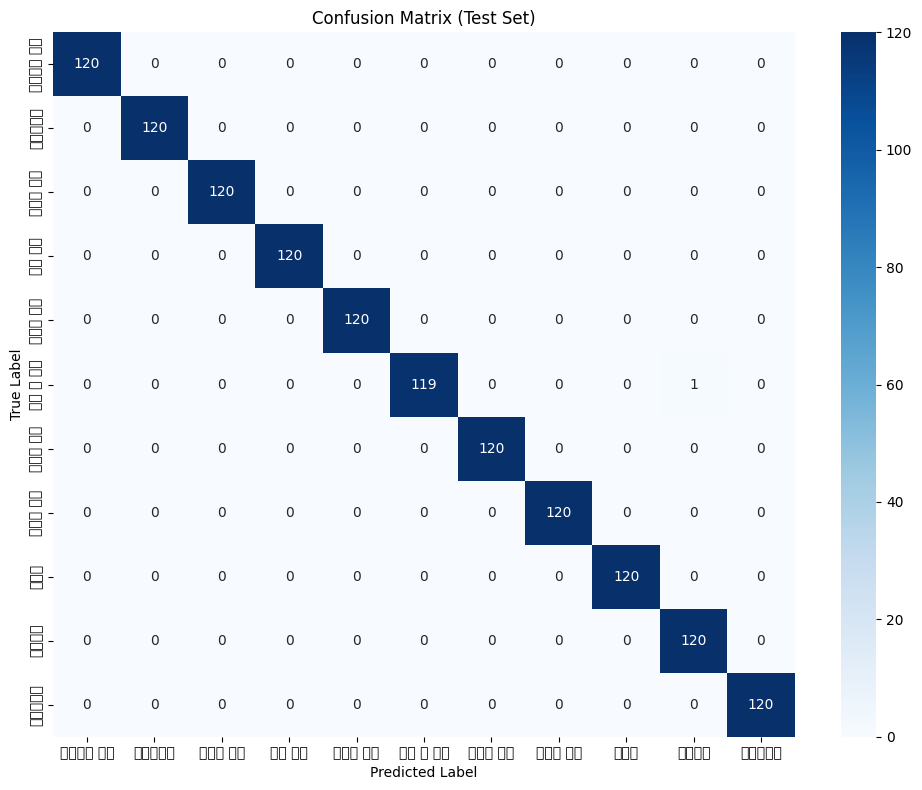

In [ ]:
# Confusion Matrix 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[id2label[i] for i in range(len(id2label))],
    yticklabels=[id2label[i] for i in range(len(id2label))]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

# 상담 데이터셋 로드

In [ ]:
import json
import pandas as pd

def json_to_dataframe(json_path):
    try:
        # 1) JSON 파일 로드
        with open(json_path, "r", encoding="utf-8") as f:
            data = json.load(f)

        rows = []

        # 2) paragraph 순회
        for p in data.get("paragraph", []):
            # 내담자 발화만 선택
            if p.get("paragraph_speaker") == "내담자":
                rows.append({
                    "id": data.get("id"),
                    "age": data.get("age"),
                    "gender": data.get("gender"),
                    "depression": data.get("depression"),
                    "anxiety": data.get("anxiety"),
                    "addiction": data.get("addiction"),
                    "class": data.get("class"),
                    "summary": data.get("summary"),
                    "silence": data.get("silence"),
                    "total_time": data.get("total_time"),
                    "text": p.get("paragraph_text")
                })

        # 3) DataFrame 생성
        df = pd.DataFrame(rows)
        return df
    except json.JSONDecodeError as e:
        print(f"JSONDecodeError in file: {json_path}. Error: {e}")
        return pd.DataFrame() # 오류 발생 시 빈 DataFrame 반환

In [ ]:
# 여러 json 읽기
import glob

def json_folder_to_dataframe(folder_path):
    all_dfs = []

    for file in glob.glob(f"{folder_path}/*.json"):
        df = json_to_dataframe(file)
        if not df.empty:
            all_dfs.append(df)

    if all_dfs:
        return pd.concat(all_dfs, ignore_index=True)
    else:
        return pd.DataFrame()


In [ ]:
df_all = json_folder_to_dataframe("/content/drive/MyDrive/자연어처리_시험대체/data/상담데이터/우울증")
df_all.shape


(54793, 11)

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/자연어처리_시험대체/data/상담데이터/우울증_df/consult_text.csv")

In [ ]:
display(df.columns)

Index(['id', 'age', 'gender', 'depression', 'anxiety', 'addiction', 'class',
       'summary', 'silence', 'total_time', 'text', 'sentences', 'sentence_cnt',
       'utterance_label'],
      dtype='object')

In [ ]:
max_len = df_all["text"].str.len().max()
longest_text = df_all[df_all["text"].str.len() == max_len]["text"].iloc[0]
print(longest_text)
print(len(longest_text))

어떤 일이었냐면 저희가 이제 올해부터 이제 유아들을 상대로, 저는 유아들을 보고 있거든요. 유아들을 상대로 교육을 해줘요. 이제 @TIME에서 @TIME 사이, 이제 A 타임, B 타임으로 나눠서 이제 교육을 하는데 그러니까 교육을 하러 올라가면 2층으로 올라가면 1층에 남아서 제가 애들을 보거든요, 그 시간에. 근데 돌아가면서 선생님들이 월, 화, 수, 목, 금, 토, 일 이렇게 돌아가면서 해주다 보니까 이제 저는 그때 이제 2층에서 수업받는 애들 말고 밑에 있는 애들을 봐줘야 되니까 그때가 한 13명, 12명 그렇게 됐는데 첫 번째는 두 가지 문제가 있었어요. 첫 번째는 원래 영아하고 유아하고 같이 놀이는 안 되거든요. 원래는 법적으로. 영아는 영아끼리 놀아야 되고 유아는 유아끼리 분리를 해야 되는데 이 선생님이 이제 4살짜리 애들이 한 교실에 9명이 있어서 너무 많으니까 이 애들을 저한테 보라고 하더라고요. 몇 명을 데리고 가서. 유아 쪽에 데리고 가서 보라고 하더라고요. 근데 문득 몇 년 전만 해도 @TITLE이 분리를 시켜라, 같이 보는 건 안 된다 했었는데 이제 이 선생님은 나를 믿으니까 그렇게 말씀하신 거예요. 근데 나는 이제 생각에 그러면 선생님 그러면 영아들은 0세들은 지금 몇 명이에요? 1세들은 지금 몇 명이에요? 0세들은 그럼 누가 봐요? 이렇게 내가 물은 거예요, 자꾸. 그래서 이렇게 쭉 설명을 해주더라고요. 그래서 알겠다 해서 했는데 그다음 날 이제 저를 불러다가 되게 섭섭했다고 하더라고요. 그래서 왜요, 왜요? 저도 모르고 왜요 했는데 알고 보니까 자기가 그런 말 했을 때 내가 네, 당연하죠. 제가 봐 드릴게요. 이렇게 대답이 올 줄 알았는데 자꾸 제가 자꾸 물으니까 거기에 대해서 기분이 나빴다고 솔직하게 말씀하시는 거예요. 근데 이제 저는 제 생각을, 근데 선생님은 무슨 의도로 그렇게 말했는지 궁금하다. 이렇게 그래서 제가 그랬어요. 제가 선생님이 그 선생님은 이제 @TITLE이면서 영아 연장으로 돼 있거든요. 교사로 같이 겸용이 돼

# 내담자 발언 텍스트 처리

## 1.문장 분리기

In [ ]:
import re
from typing import List
from transformers import PreTrainedTokenizer

# ==============================
# 1. 사고 전환 트리거 정의
# ==============================
# 인지왜곡이 시작되기 쉬운 접속어 / 추론어 / 일반화 표현들
TRIGGERS = [
    "아마", "분명", "당연히", "왠지", "혹시",
    "그래서", "결국", "역시", "항상", "절대",
    "하지만", "근데", "그래도",
    "때문에", "해서", "그러니까",
    "다음엔", "앞으로", "또", "분명히"
]

# 종결 부호 패턴
END_PUNCT = r"[.!?…]+"

# 트리거 단어 앞에서 분리하기 위한 정규식
# look-behind 없이 Python re에서 안전하게 동작
TRIGGER_PATTERN = re.compile(
    r"(?:^|\s)(" + "|".join(map(re.escape, TRIGGERS)) + r")(?=\s)",
    flags=re.UNICODE
)

# ==============================
# 2. 텍스트 정규화
# ==============================
def normalize_text(text: str) -> str:
    """
    - 앞뒤 공백 제거
    - 줄바꿈/탭 → 공백
    - 중복 공백 정리
    """
    text = text.strip()
    text = re.sub(r"[\t\r\n]+", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

# ==============================
# 3. 종결부호 기준 1차 분리
# ==============================
def split_by_punct(text: str) -> List[str]:
    """
    마침표/물음표/느낌표/… 기준 문장 분리
    """
    if not text:
        return []

    sentences = []
    last_end = 0

    for match in re.finditer(END_PUNCT, text):
        sentence = text[last_end:match.end()].strip()
        if sentence:
            sentences.append(sentence)
        last_end = match.end()

    # 마지막에 종결부호 없는 잔여 텍스트 처리
    if last_end < len(text):
        remaining = text[last_end:].strip()
        if remaining:
            sentences.append(remaining)

    return sentences

# ==============================
# 4. 사고 전환 트리거 기준 2차 분리
# ==============================
def split_by_triggers(sentence: str) -> List[str]:
    """
    '그래서 / 아마 / 하지만 ...' 앞에서 사고 단위 분리
    """
    s = sentence.strip()
    if not s:
        return []

    matches = list(TRIGGER_PATTERN.finditer(s))
    if not matches:
        return [s]

    cut_points = [0] + [m.start(1) for m in matches] + [len(s)]
    chunks = []

    for i in range(len(cut_points) - 1):
        chunk = s[cut_points[i]:cut_points[i + 1]].strip()
        if chunk:
            chunks.append(chunk)

    return chunks

# ==============================
# 5. 너무 짧은 조각 병합
# ==============================
def merge_short_chunks(chunks: List[str], min_len: int = 8) -> List[str]:
    """
    너무 짧게 쪼개진 문장은 앞 문장과 병합
    (ex: '그래서' 단독 방지)
    """
    merged = []

    for ch in chunks:
        if not merged:
            merged.append(ch)
            continue

        if len(ch) < min_len or ch in TRIGGERS:
            merged[-1] = (merged[-1] + " " + ch).strip()
        else:
            merged.append(ch)

    return [re.sub(r"\s{2,}", " ", m).strip() for m in merged if m.strip()]

# ==============================
# 6. 토큰 길이 초과 시 분리
# ==============================
def split_by_token_limit(
    text: str,
    tokenizer: PreTrainedTokenizer,
    max_length: int,
    stride: int = 0,
) -> List[str]:
    """
    tokenizer 기준 max_length 초과 문장 분리
    """
    enc = tokenizer(
        text,
        truncation=True,
        max_length=max_length,
        stride=stride,
        return_overflowing_tokens=True,
        add_special_tokens=True,
        padding=False,
    )

    return [
        tokenizer.decode(ids, skip_special_tokens=True).strip()
        for ids in enc["input_ids"]
        if ids
    ]

# ==============================
# 7. 최종 CBT 문장 분리기
# ==============================
def split_utterance_for_cbt(
    text: str,
    tokenizer: PreTrainedTokenizer,
    max_length: int = 128,
    min_chunk_len: int = 8,
) -> List[str]:
    """
    내담자 한 턴 발언 → 인지왜곡 분류용 문장 리스트
    """
    text = normalize_text(text)

    # 1차: 종결부호
    sentences = split_by_punct(text)

    out = []
    for sent in sentences:
        # 2차: 사고 전환
        chunks = split_by_triggers(sent)
        chunks = merge_short_chunks(chunks, min_len=min_chunk_len)

        # 3차: 토큰 길이 제한
        for ch in chunks:
            tok_len = len(tokenizer(ch, add_special_tokens=True)["input_ids"])
            if tok_len <= max_length:
                out.append(ch)
            else:
                out.extend(
                    split_by_token_limit(
                        ch,
                        tokenizer=tokenizer,
                        max_length=max_length,
                        stride=0
                    )
                )

    # 최종 안정화
    return merge_short_chunks(out, min_len=min_chunk_len)


# 2.DataFrame 에 태우는 방법

In [ ]:
display(df.columns)

Index(['id', 'age', 'gender', 'depression', 'anxiety', 'addiction', 'class',
       'summary', 'silence', 'total_time', 'text', 'sentences', 'sentence_cnt',
       'utterance_label'],
      dtype='object')

In [ ]:
from tqdm.auto import tqdm

tqdm.pandas()

# 1. 문장 분리 결과 리스트 컬럼
df["sentences"] = df["text"].progress_apply(
    lambda x: split_utterance_for_cbt(
        text=x,
        tokenizer=tokenizer,
        max_length=128,
        min_chunk_len=8
    )
)

# 2. 문장 개수
df["sentence_cnt"] = df["sentences"].apply(len)

# 0. 발언 ID 추가
df["utterance_id"] = df.index


# 3. sentence-level DF 생성
df_sentence = (
    df[["utterance_id", "text", "sentences"]]
    .explode("sentences")
    .rename(columns={"sentences": "sentence"})
    .reset_index(drop=True)
)


# 4. 문장 길이
df_sentence["char_len"] = df_sentence["sentence"].str.len()



  0%|          | 0/54793 [00:00<?, ?it/s]

In [ ]:
display(df_sentence.head())
display(df.columns)

,utterance_id,text,sentence,char_len,pred_label,pred_score
0,0,안녕하세요.,안녕하세요.,6,10,0.998154
1,1,네.,네.,2,10,0.990861
2,2,반갑습니다.,반갑습니다.,6,10,0.998208
3,3,시간대랑 그것 외에는.,시간대랑 그것 외에는.,12,2,0.967105
4,4,네.,네.,2,10,0.990861


Index(['id', 'age', 'gender', 'depression', 'anxiety', 'addiction', 'class',
       'summary', 'silence', 'total_time', 'text', 'sentences', 'sentence_cnt',
       'utterance_label', 'utterance_id'],
      dtype='object')

In [ ]:
# label → id 변환 함수
def label_to_id(label: str) -> int:
    # Use the predefined label2id mapping
    return label2id[label]

# batch 예측 함수
def predict_with_pipeline_with_score(sentences, classifier, label2id, batch_size=32):
    pred_labels = []
    pred_scores = []

    for i in tqdm(range(0, len(sentences), batch_size)):
        batch = sentences[i:i + batch_size]
        outputs = classifier(batch, truncation=True)

        for out in outputs:
            label_id = label_to_id(out["label"])
            pred_labels.append(label_id)
            pred_scores.append(out["score"])

    return pred_labels, pred_scores


In [ ]:
# 5. pred_label 컬럼 생성
df_sentence["pred_label"], df_sentence["pred_score"] = (
    predict_with_pipeline_with_score(
        sentences=df_sentence["sentence"].tolist(),
        classifier=classifier,
        label2id=label2id,
        batch_size=32
    )
)

  0%|          | 0/4524 [00:00<?, ?it/s]

# 3.모델 예측 결과 집계(문장 -> 발언)


| 컬럼                      | 단계 | 역할            |
| ----------------------- | -- | ------------- |
| `text`                  | 입력 | 발언 원문         |
| `sentence_labels`       | 중간 | 문장별 모델 출력     |
| `utterance_labels`      | 핵심 | 발언 단위 인지왜곡 구조 |
| `utterance_multihot`    | 분석 | 수치화된 벡터       |
| `utterance_label_names` | 해석 | 사람이 읽는 결과     |


In [ ]:
from collections import defaultdict
import numpy as np

NONE_ID = label2id["비인지왜곡"]
NUM_LABELS = len(label2id)
id2label = {v: k for k, v in label2id.items()}

def agg_multilabel_score_count(
    labels,
    scores,
    none_id=NONE_ID,
    min_count=2,
    min_score=0.8
):
    """
    문장 단위 (label, score) -> 발언 단위 multi-label

    채택 조건:
    - 동일 라벨이 min_count 이상 등장
      OR
    - 해당 라벨의 max score >= min_score

    비인지왜곡은 다른 왜곡이 있으면 제거
    """
    stat = defaultdict(lambda: {"count": 0, "max_score": 0.0})

    for l, s in zip(labels, scores):
        if l == none_id:
            continue
        stat[l]["count"] += 1
        stat[l]["max_score"] = max(stat[l]["max_score"], s)

    kept = [
        l for l, v in stat.items()
        if (v["count"] >= min_count) or (v["max_score"] >= min_score)
    ]

    return sorted(kept) if kept else [none_id]

def to_multihot(labels, n=NUM_LABELS):
    v = np.zeros(n, dtype=np.int8)
    for l in labels:
        v[l] = 1
    return v


In [ ]:
utterance_multilabel = (
    df_sentence
    .groupby("utterance_id")
    .agg(
        sentence_labels=("pred_label", list),
        sentence_scores=("pred_score", list),
        text=("text", "first")
    )
    .reset_index()
)

utterance_multilabel["utterance_labels"] = (
    utterance_multilabel.apply(
        lambda r: agg_multilabel_score_count(
            r["sentence_labels"],
            r["sentence_scores"],
            min_count=2,
            min_score=0.8
        ),
        axis=1
    )
)

utterance_multilabel["utterance_multihot"] = (
    utterance_multilabel["utterance_labels"].apply(to_multihot)
)

utterance_multilabel["utterance_label_names"] = (
    utterance_multilabel["utterance_labels"]
    .apply(lambda ids: [id2label[i] for i in ids])
)


In [ ]:
display(utterance_multilabel)

,utterance_id,sentence_labels,sentence_scores,text,utterance_labels,utterance_multihot,utterance_label_names
0,0,[10],[0.9981536269187927],안녕하세요.,[10],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",[비인지왜곡]
1,1,[10],[0.9908612966537476],네.,[10],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",[비인지왜곡]
2,2,[10],[0.9982078075408936],반갑습니다.,[10],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",[비인지왜곡]
3,3,[2],[0.9671046733856201],시간대랑 그것 외에는.,[2],"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",[정신적 여과]
4,4,[10],[0.9908612966537476],네.,[10],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",[비인지왜곡]
...,...,...,...,...,...,...,...
54788,54788,[6],[0.7495778203010559],그래야지 나도 @SCHOOL에 애정을 갖고 계속해서 포기하지 않고 이분들 만나야지만...,[10],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",[비인지왜곡]
54789,54789,[10],[0.9960095882415771],"네, 교수님 그럴게요.",[10],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",[비인지왜곡]
54790,54790,"[10, 1]","[0.9980983138084412, 0.9406466484069824]",교수님 감사합니다. 다음에 또 봬요.,[1],"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[과잉일반화]
54791,54791,[10],[0.9962777495384216],"네, 그렇게 할게요.",[10],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",[비인지왜곡]


In [ ]:
utterance_multilabel.to_csv("/content/drive/MyDrive/자연어처리_시험대체/output/utterance_multilabel.csv", index=False, encoding="utf-8-sig")

# 99. 모델 다시 불러오기


In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

LOAD_DIR = "/content/drive/MyDrive/자연어처리_시험대체/output/cbt_roberta_base/20251215_1"

tokenizer = AutoTokenizer.from_pretrained(LOAD_DIR)
model = AutoModelForSequenceClassification.from_pretrained(LOAD_DIR)
